In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import numpy as np

# Bước 1: Đọc dữ liệu
df = pd.read_csv('xAPI-Edu-Data.csv')
df = df.drop(columns=['StageID','GradeID','SectionID','Semester'])
print(df.isnull().sum())

gender                      0
NationalITy                 0
PlaceofBirth                0
Topic                       0
Relation                    0
raisedhands                 0
VisITedResources            0
AnnouncementsView           0
Discussion                  0
ParentAnsweringSurvey       0
ParentschoolSatisfaction    0
StudentAbsenceDays          0
Class                       0
dtype: int64


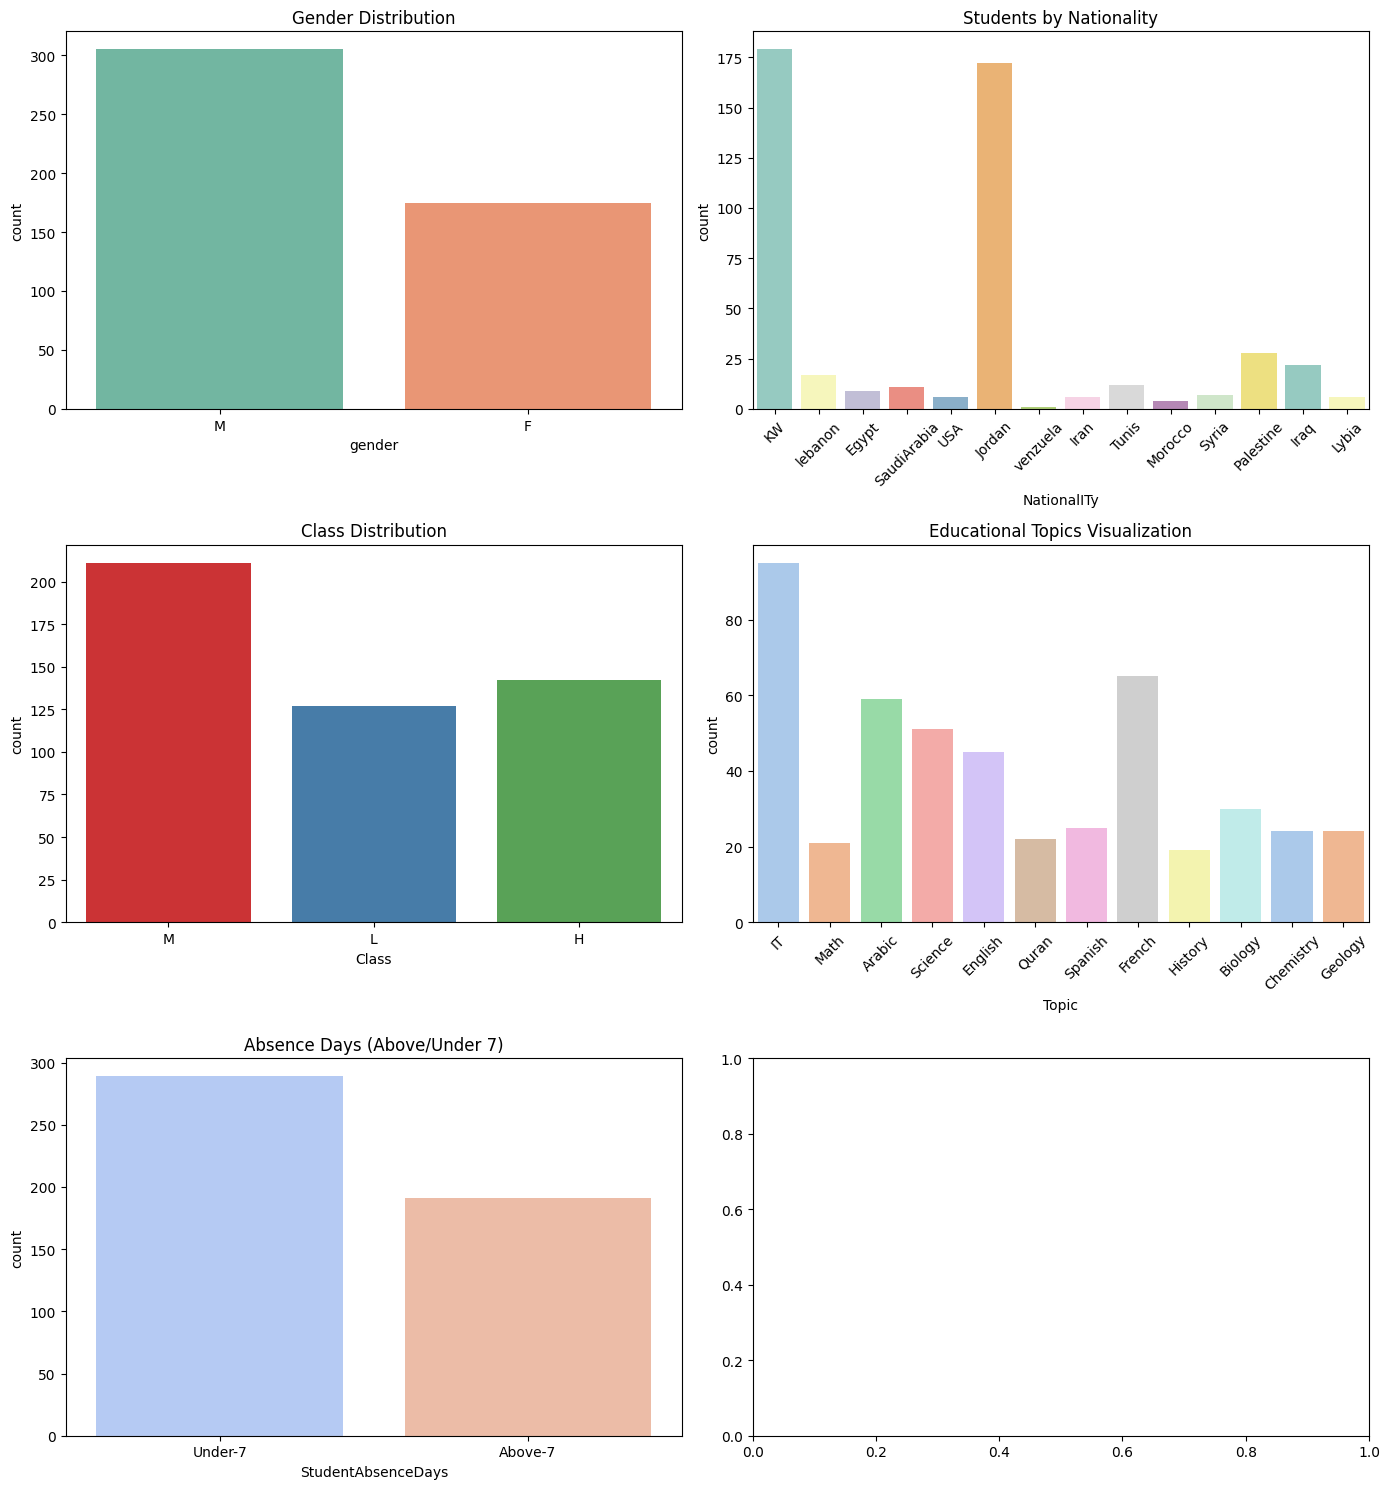

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo Figure và Subplot
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Biểu đồ Giới tính
sns.countplot(ax=axes[0, 0], x='gender', hue='gender', data=df, palette='Set2', legend=False)
axes[0, 0].set_title('Gender Distribution')

# Biểu đồ Quốc gia
sns.countplot(ax=axes[0, 1], x='NationalITy', hue='NationalITy', data=df, palette='Set3', legend=False)
axes[0, 1].set_title('Students by Nationality')
axes[0, 1].tick_params(axis='x', rotation=45)

# Biểu đồ Class
sns.countplot(ax=axes[1, 0], x='Class', hue='Class', data=df, palette='Set1', legend=False)
axes[1, 0].set_title('Class Distribution')

# Biểu đồ Chủ đề môn học
sns.countplot(ax=axes[1, 1], x='Topic', hue='Topic', data=df, palette='pastel', legend=False)
axes[1, 1].set_title('Educational Topics Visualization')
axes[1, 1].tick_params(axis='x', rotation=45)

# Biểu đồ Số ngày nghỉ
sns.countplot(ax=axes[2, 0], x='StudentAbsenceDays', hue='StudentAbsenceDays', data=df, palette='coolwarm', legend=False)
axes[2, 0].set_title('Absence Days (Above/Under 7)')

# Căn chỉnh khoảng cách
plt.tight_layout()
plt.show()

   gender  NationalITy  PlaceofBirth  Topic  Relation  raisedhands  \
0       1            4             4      7         0    -1.033429   
1       1            4             4      7         0    -0.870813   
2       1            4             4      7         0    -1.196046   
3       1            4             4      7         0    -0.545579   
4       1            4             4      7         0    -0.220346   

   VisITedResources  AnnouncementsView  Discussion  ParentAnsweringSurvey  \
0         -1.174075          -1.351167   -0.843326                      1   
1         -1.053029          -1.313549   -0.662225                      1   
2         -1.446426          -1.426401   -0.481125                      0   
3         -0.901723          -1.238315   -0.300024                      0   
4         -0.145191          -0.974994    0.243279                      0   

   ParentschoolSatisfaction  StudentAbsenceDays  Class  
0                         1                   1      1  
1 

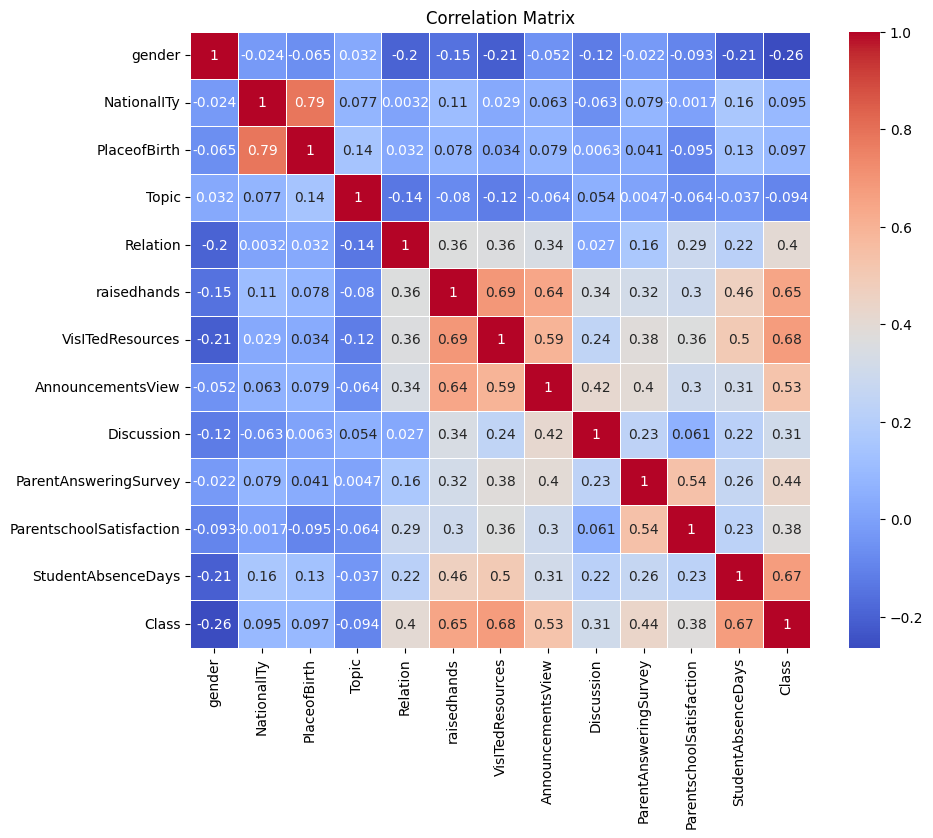

In [3]:
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['NationalITy'] = le.fit_transform(df['NationalITy'])
df['PlaceofBirth'] = le.fit_transform(df['PlaceofBirth'])
df['Topic'] = le.fit_transform(df['Topic'])
df['Relation'] = le.fit_transform(df['Relation'])
df['ParentAnsweringSurvey'] = le.fit_transform(df['ParentAnsweringSurvey'])
df['ParentschoolSatisfaction'] = le.fit_transform(df['ParentschoolSatisfaction'])
df['StudentAbsenceDays'] = le.fit_transform(df['StudentAbsenceDays'])
df['Class'] = df['Class'].map({'L': 0, 'M': 1, 'H': 2})

# Chuẩn hóa các giá trị số
scaler = StandardScaler()
numeric_columns = ['raisedhands', 'VisITedResources', 'AnnouncementsView', 'Discussion']
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# In dữ liệu đã chuẩn hóa
print(df.head())
# Tính toán ma trận tương quan
correlation_matrix = df.corr()

# Vẽ biểu đồ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Bước 6: Tách X (features) và y (label)
X = df.drop('Class', axis=1)
y = df['Class']

# Chia train-test với stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

# Danh sách lưu kết quả
results = []

# Lưới tham số tối ưu cho XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 150],       # Số cây
    'max_depth': [3, 5, 7],                # Độ sâu tối đa
    'learning_rate': [0.01, 0.1, 0.2],    # Tốc độ học
    'subsample': [0.8, 1.0],               # Tỉ lệ mẫu dùng cho mỗi cây
    'colsample_bytree': [0.8, 1.0],        # Tỉ lệ feature dùng cho mỗi cây
    'gamma': [0, 0.1, 0.2]                 # Minimum loss reduction để tách node
}

# Duyệt random_state từ 30-42
for random_state in [32,33,36,37,38,39,41,42]:
    print(f"\nĐang xử lý với random_state = {random_state}")
    
    # Duyệt số lượng đặc trưng từ 7-12
    for n_features in range(7, 13):
        print(f"  → Số đặc trưng: {n_features}")
        
        # Chọn đặc trưng bằng RFE (dùng DecisionTree làm base estimator)
        rfe_selector = RFE(
            estimator=DecisionTreeClassifier(random_state=random_state),
            n_features_to_select=n_features
        )
        X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
        X_test_rfe = rfe_selector.transform(X_test)
        
        # Tìm tham số tối ưu bằng GridSearchCV
        xgb_grid = GridSearchCV(
            estimator=XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='logloss'),
            param_grid=xgb_param_grid,
            cv=10,
            scoring='accuracy',
            n_jobs=-1
        )
        xgb_grid.fit(X_train_rfe, y_train)
        
        # Lấy model tốt nhất
        best_xgb = xgb_grid.best_estimator_
        
        # Dự đoán trên tập test
        y_pred = best_xgb.predict(X_test_rfe)
        acc = accuracy_score(y_test, y_pred)
        
        print(f"    Độ chính xác: {acc:.4f}")
        print(f"    Tham số tối ưu: {xgb_grid.best_params_}")
        
        # Lưu kết quả
        results.append({
            'random_state': random_state,
            'n_features': n_features,
            'accuracy': acc,
            'best_params': xgb_grid.best_params_
        })

# Xuất kết quả ra CSV
pd.DataFrame(results).to_csv('xgb_optimization_results.csv', index=False)
print("\nĐã lưu kết quả vào 'xgb_optimization_results.csv'")


Đang xử lý với random_state = 32
  → Số đặc trưng: 7


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:30:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7500
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 8


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:31:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8229
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 9


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:32:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8125
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 10


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:33:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7917
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 11


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:34:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7917
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 12


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:35:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8021
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}

Đang xử lý với random_state = 33
  → Số đặc trưng: 7


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:35:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7292
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 8


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:36:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7500
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
  → Số đặc trưng: 9


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:37:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8333
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
  → Số đặc trưng: 10


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:38:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8021
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1.0}
  → Số đặc trưng: 11


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8021
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
  → Số đặc trưng: 12


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:39:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8125
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 1.0}

Đang xử lý với random_state = 36
  → Số đặc trưng: 7


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:40:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7500
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
  → Số đặc trưng: 8


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:41:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8021
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 9


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:41:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7708
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 10


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:42:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8333
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 11


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:43:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8333
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 12


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:44:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8125
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}

Đang xử lý với random_state = 37
  → Số đặc trưng: 7


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:44:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.6979
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 8


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:45:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8229
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
  → Số đặc trưng: 9


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:46:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8125
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}
  → Số đặc trưng: 10


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:46:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8229
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 11


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7917
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
  → Số đặc trưng: 12


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8021
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}

Đang xử lý với random_state = 38
  → Số đặc trưng: 7


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:48:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7396
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 8


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:49:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8229
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}
  → Số đặc trưng: 9


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:49:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8125
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}
  → Số đặc trưng: 10


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:50:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7812
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 11


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:51:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8021
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 1.0}
  → Số đặc trưng: 12


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:52:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8125
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}

Đang xử lý với random_state = 39
  → Số đặc trưng: 7


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:52:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7917
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
  → Số đặc trưng: 8


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:53:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7396
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
  → Số đặc trưng: 9


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:53:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8021
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 10


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:54:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8125
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
  → Số đặc trưng: 11


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:55:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7917
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 12


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8229
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}

Đang xử lý với random_state = 41
  → Số đặc trưng: 7


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7500
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
  → Số đặc trưng: 8


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:57:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8125
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
  → Số đặc trưng: 9


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:57:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8021
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
  → Số đặc trưng: 10


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:58:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7708
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 11


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:58:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8125
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 12


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:59:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8021
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}

Đang xử lý với random_state = 42
  → Số đặc trưng: 7


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:00:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7292
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
  → Số đặc trưng: 8


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:00:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7396
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 9


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:01:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8021
    Tham số tối ưu: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 10


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:02:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7917
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}
  → Số đặc trưng: 11


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:03:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.7708
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}
  → Số đặc trưng: 12


c:\Users\NGUYEN GIA KHANH\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:03:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


    Độ chính xác: 0.8021
    Tham số tối ưu: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}

Đã lưu kết quả vào 'xgb_optimization_results.csv'
